In [1]:
from pathlib import Path
import json
import os
import joblib
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis, pearsonr
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
## Mauvaise prediction de la classe 1 pour l'instant
## Regarder pour scaler les trucs pour chaque signal et pas accros tout les samples 
## Cyp affirme que le choix du model et des parametre ne devrait pas faire autant de diff avec le top du leaderbord, c'est qu il nous faut des meilleur feature
## Donne code + papier d'edunao a claude et ameliorer les features
## Une piste pourrait etre d'utiliser un des 7 signaux (individu) comme test set, parce je crois que la on overfit peut etre trop aux individus que nous on a (et qui ne sont pas dans le test set )

In [2]:
# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Load Data and create Features

In [3]:
## Load data

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]

        ########### Scale the signal
        signal = (signal - signal.mean(axis=1, keepdims=True)) / (signal.std(axis=1, keepdims=True) + 1e-8)
        
        ###########
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)

    return main_df



df = format_data(True)

In [4]:
df      ## On a les time series pour chaque capteur pour chaque label

,captor_0,captor_1,captor_2,captor_3,captor_4,target,num_epoch,num_signal
0,"[-0.956676, -0.5598582, -0.18814908, -0.122557...","[-0.32375595, -0.31785807, -0.35543644, -0.423...","[-0.4472984, -0.41811013, -0.4307091, -0.53272...","[-0.03179601, -0.417376, -0.7360724, -0.831345...","[0.04032295, 0.015750108, -0.038219586, 0.0033...",0,0,0
1,"[-0.014565176, -0.15585695, -0.31212378, -0.28...","[0.36450285, 0.38835868, 0.46126607, 0.5384493...","[-0.04144291, -0.118574046, -0.13706419, -0.04...","[-0.0615589, -0.07625791, 0.004265773, 0.08502...","[-0.45007923, -0.5190569, -0.5870507, -0.58260...",0,1,0
2,"[0.0051709157, 0.0058272164, 0.011522705, -0.0...","[-0.010070225, -0.033969346, -0.03454658, -0.0...","[0.038264908, 0.11190618, 0.18740298, 0.209739...","[-0.04357999, 0.08432934, 0.22008629, 0.301986...","[0.03642508, 0.10727353, 0.15827331, 0.2006583...",0,2,0
3,"[0.45006445, 0.36421528, 0.073634245, 0.000427...","[0.33464733, 0.21952774, 0.10330197, 0.1062366...","[0.23298864, 0.09477392, -0.095575795, -0.0626...","[0.066243924, -0.28198528, -0.39446655, -0.266...","[-0.52855635, -0.49503663, -0.19944486, 0.0243...",0,3,0
4,"[0.050896704, -0.1539046, -0.19590649, -0.1646...","[0.13570462, 0.092063226, 0.15222359, 0.213477...","[0.029725593, -0.12783302, -0.18444146, -0.168...","[-0.27587023, -0.2954542, -0.18412773, -0.0181...","[-0.20451611, -0.25388643, -0.2724289, -0.2730...",0,4,0
...,...,...,...,...,...,...,...,...
7428,"[0.62668264, 0.7531795, 0.8398116, 0.19678582,...","[0.8210523, 0.6130647, 0.37354162, 0.26302022,...","[0.44055417, 0.5686605, 0.5873838, 0.1679903, ...","[0.20576736, 0.35084805, 0.30968362, 0.3422976...","[-0.7172806, -0.21195255, -0.15922265, -0.2194...",0,977,7
7429,"[1.0097458, 1.8440588, 0.8733868, 0.96079636, ...","[0.78154427, 0.82401407, 0.7126922, 0.67714375...","[1.0230542, 1.5457592, 0.7488009, 0.7221392, 0...","[0.80834925, 0.6559728, 0.47251692, 0.28343344...","[0.15648164, -0.057477478, 0.09304801, 0.02548...",0,978,7
7430,"[-1.505261, -2.5308378, -2.5402048, -1.8118773...","[-2.5853121, -2.5679343, -2.1122754, -1.648666...","[-3.5714624, -4.313865, -4.320343, -3.873194, ...","[-2.9187224, -2.7299018, -2.6270587, -2.709907...","[-2.3746421, -2.2720602, -3.105388, -3.9698262...",0,979,7
7431,"[-2.0801861, -1.0348264, -0.91712207, -1.41965...","[-0.4816826, -0.5125609, -0.49482858, -0.27361...","[-2.4141755, -1.6285331, -1.7035432, -1.968739...","[-1.5526174, -1.5779645, -1.8928668, -1.456320...","[-1.5083997, -0.5651852, -0.5600037, -1.253484...",0,980,7


In [ ]:
## On extract les features de ce qui precede

import numpy as np
from scipy.signal import welch
from itertools import permutations


def extract_time_features(signal):
    """Extract time domain features from a signal."""
    features = {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'min': float(np.min(signal)),
        'max': float(np.max(signal)),
        'ptp': float(np.ptp(signal)),
        'skew': float(skew(signal)),
        'kurtosis': float(kurtosis(signal)),
        'rms': float(np.sqrt(np.mean(signal**2))),
        'median': float(np.median(signal))
    }
    return features


def spectral_entropy(psd):
    """Spectral entropy from a PSD array."""
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return -np.sum(psd_norm * np.log(psd_norm + 1e-12))


def permutation_entropy(signal, order=3, delay=1):
    """Permutation entropy of a 1D signal."""
    n = len(signal)
    perms = list(permutations(range(order)))
    c = np.zeros(len(perms))

    for i in range(n - delay * (order - 1)):
        pattern = signal[i:i + delay * order:delay]
        rank = tuple(np.argsort(pattern))
        c[perms.index(rank)] += 1

    p = c / np.sum(c) if np.sum(c) > 0 else c
    p = p[p > 0]

    return -np.sum(p * np.log(p))



def extract_frequency_features(signal):
    """Extract frequency domain + entropy features from a signal."""
    features = {}
    
    # PSD using Welch (already correct)
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)

    # ---------- GLOBAL SPECTRAL ENTROPY ----------
    features['spectral_entropy'] = float(spectral_entropy(psd))

    # Define sleep frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }

    # ---------- BAND FEATURES + BAND ENTROPY ----------
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)

        if np.any(band_mask):
            band_psd = psd[band_mask]
            band_power = np.sum(band_psd)

            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(
                band_power / total_power if total_power > 0 else 0
            )

            # Band spectral entropy
            features[f'{band_name}_entropy'] = float(
                spectral_entropy(band_psd)
            )
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
            features[f'{band_name}_entropy'] = 0.0

    # Spectral edge frequency (95%)
    cumsum_psd = np.cumsum(psd)
    if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
        sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
        features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)

    features['total_power'] = float(total_power)

    return features


def extract_channel_features(channel_signal):
    """Extract all features for a single channel."""
    time_features = extract_time_features(channel_signal)
    freq_features = extract_frequency_features(channel_signal)

    # ---------- PERMUTATION ENTROPY ----------
    time_features['permutation_entropy'] = float(
        permutation_entropy(channel_signal, order=3, delay=1)
    )

    return {**time_features, **freq_features}


def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean_{window}'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std_{window}'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff_{window}'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features

def create_features(df):
    print(f"Processing {len(df)} epochs...")
    
    # Process each row to extract features
    all_features = []
    
    for i, row in df.iterrows():
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(df)} epochs")
        
        features = process_single_epoch(row)
        all_features.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    
    # Add temporal context
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df, 3)
    features_df = add_temporal_context(features_df, 50)
    features_df = add_temporal_context(features_df, 500)
    features_df = add_temporal_context(features_df, 1000)
    
    return features_df


# Create the submission file
def create_submission(df_test, predictions, file_name = ''):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv(file_name + 'submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission



## New function that speeds up the computation
from joblib import Parallel, delayed

def create_features_parallel(df):
    print(f"Processing {len(df)} epochs in parallel...")
    
    # Run process_single_epoch across all available CPU cores
    results = Parallel(n_jobs=-1)(
        delayed(process_single_epoch)(row) for _, row in df.iterrows()
    )
    
    features_df = pd.DataFrame(results)
    
    # Temporal context remains sequential as it depends on ordering
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df, 3)
    features_df = add_temporal_context(features_df, 50)
    features_df = add_temporal_context(features_df, 500)
    return features_df



df_features = create_features_parallel(df)

Processing 7433 epochs in parallel...
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import welch
from scipy.stats import skew, kurtosis, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Constants
SAMPLING_RATE = 100  # Hz
SAMPLES_PER_EPOCH = 3000  # 30 seconds at 100 Hz
NUM_CHANNELS = 5

# ========== OPTIMIZED TIME DOMAIN FEATURES ==========
def extract_time_features(signal):
    """Extract only the most important time domain features."""
    return {
        'std': float(np.std(signal)),
        'mean': float(np.mean(signal)),
        'ptp': float(np.ptp(signal)),  # Peak-to-peak is often more useful than min/max separately
        'rms': float(np.sqrt(np.mean(signal**2)))
    }

# ========== OPTIMIZED FREQUENCY DOMAIN FEATURES ==========
def extract_frequency_features(signal):
    """Extract essential frequency domain features."""
    features = {}
    
    # Calculate power spectral density ONCE
    freqs, psd = welch(signal, fs=SAMPLING_RATE, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)
    
    # Focus on the most important sleep bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'sigma': (12, 15),
        'beta': (13, 30)
    }
    
    # Calculate power and relative power (remove peak freq - less useful)
    for band_name, (low, high) in bands.items():
        band_mask = (freqs >= low) & (freqs <= high)
        if np.any(band_mask):
            band_power = np.sum(psd[band_mask])
            features[f'{band_name}_power'] = float(band_power)
            features[f'{band_name}_rel_power'] = float(band_power / total_power if total_power > 0 else 0)
        else:
            features[f'{band_name}_power'] = 0.0
            features[f'{band_name}_rel_power'] = 0.0
    
    # Key power ratios (most discriminative for sleep stages)
    delta_power = features.get('delta_power', 1e-10)
    theta_power = features.get('theta_power', 1e-10)
    alpha_power = features.get('alpha_power', 1e-10)
    
    features['theta_delta_ratio'] = float(theta_power / delta_power if delta_power > 0 else 0)
    features['alpha_delta_ratio'] = float(alpha_power / delta_power if delta_power > 0 else 0)
    features['total_power'] = float(total_power)
    
    return features

# ========== SIMPLIFIED COMPLEXITY FEATURES ==========
def extract_complexity_features(signal):
    """Extract only the most useful complexity features."""
    features = {}
    
    # Hjorth parameters (very informative for sleep)
    diff1 = np.diff(signal)
    var0 = np.var(signal)
    var1 = np.var(diff1)
    
    features['hjorth_mobility'] = float(np.sqrt(var1 / var0) if var0 > 0 else 0)
    
    # Zero-crossing rate (simple and effective)
    zero_crossings = np.sum(np.diff(np.sign(signal)) != 0)
    features['zero_crossing_rate'] = float(zero_crossings / len(signal))
    
    # Signal energy
    features['energy'] = float(np.sum(signal**2) / len(signal))
    
    return features

# ========== ESSENTIAL CROSS-CHANNEL FEATURES ==========
def extract_cross_channel_features(channel_signals):
    """Extract only key cross-channel features."""
    features = {}
    
    # Only correlate adjacent channels (reduce from 10 to 4 correlations)
    for i in range(NUM_CHANNELS - 1):
        if len(channel_signals[i]) == len(channel_signals[i+1]) and len(channel_signals[i]) > 1:
            try:
                corr, _ = pearsonr(channel_signals[i], channel_signals[i+1])
                features[f'corr_ch{i}_ch{i+1}'] = float(corr)
            except:
                features[f'corr_ch{i}_ch{i+1}'] = 0.0
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    if len(channel_stds) > 0:
        features['spatial_std'] = float(np.std(channel_stds))
    
    return features

# ========== OPTIMIZED TEMPORAL CONTEXT ==========
def add_temporal_context(features_df, window=3):
    """Add minimal temporal features for key bands only."""
    # Focus on the most important features for sleep staging
    key_features = [
        'ch0_freq_delta_rel_power',
        'ch0_freq_theta_rel_power', 
        'ch0_freq_alpha_rel_power',
        'ch0_freq_sigma_rel_power'
    ]
    
    # Only add rolling mean (most useful temporal feature)
    for col in key_features:
        if col in features_df.columns:
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                if np.sum(mask) > window:
                    rolling_mean = features_df.loc[mask, col].rolling(window, center=True, min_periods=1).mean()
                    features_df.loc[mask, f'{col}_roll_mean'] = rolling_mean
    
    features_df = features_df.fillna(0)
    return features_df

# ========== MAIN PROCESSING FUNCTION ==========
def process_single_epoch(row):
    """Process a single epoch with optimized feature extraction."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract only essential features
        time_features = extract_time_features(signal)
        freq_features = extract_frequency_features(signal)
        complexity_features = extract_complexity_features(signal)
        
        # Combine with channel prefix
        for feat_dict, prefix in [
            (time_features, f'ch{ch}_time_'),
            (freq_features, f'ch{ch}_freq_'),
            (complexity_features, f'ch{ch}_complex_')
        ]:
            for key, value in feat_dict.items():
                features[prefix + key] = value
        
        channel_signals.append(signal)
    
    # Cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    if 'target' in row:
        features['target'] = int(row['target'])
    
    return features

# ========== CREATE FEATURES DATAFRAME ==========
def create_features_optimized(df, use_parallel=False):
    """
    Optimized feature extraction.
    
    Parameters:
    -----------
    df : DataFrame
        Input data with signal columns
    use_parallel : bool
        If True, use parallel processing (requires joblib)
    """
    print(f"Processing {len(df)} epochs...")
    print(f"Estimated features per epoch: ~{5 * (4 + 13 + 3) + 5} (down from ~500+)")
    
    if use_parallel:
        try:
            from joblib import Parallel, delayed
            print("Using parallel processing...")
            all_features = Parallel(n_jobs=-1)(
                delayed(process_single_epoch)(row) 
                for _, row in df.iterrows()
            )
        except ImportError:
            print("joblib not available, using serial processing")
            use_parallel = False
    
    if not use_parallel:
        all_features = []
        for i, row in df.iterrows():
            if i % 500 == 0:
                print(f"  Progress: {i}/{len(df)} epochs")
            
            try:
                features = process_single_epoch(row)
                all_features.append(features)
            except Exception as e:
                print(f"Error processing epoch {i}: {e}")
                features = {
                    'num_epoch': int(row['num_epoch']),
                    'num_signal': int(row['num_signal'])
                }
                if 'target' in row:
                    features['target'] = int(row['target'])
                all_features.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    
    # Add temporal context
    print("Adding temporal context...")
    features_df = add_temporal_context(features_df)
    
    print(f"Feature extraction complete. Shape: {features_df.shape}")
    
    return features_df


# Usage:
# df_features_optimized = create_features_optimized(df, use_parallel=True)

Processing 7433 epochs...
Estimated features per epoch: ~105 (down from ~500+)
Using parallel processing...
Adding temporal context...
Feature extraction complete. Shape: (7433, 112)


## Data exploration

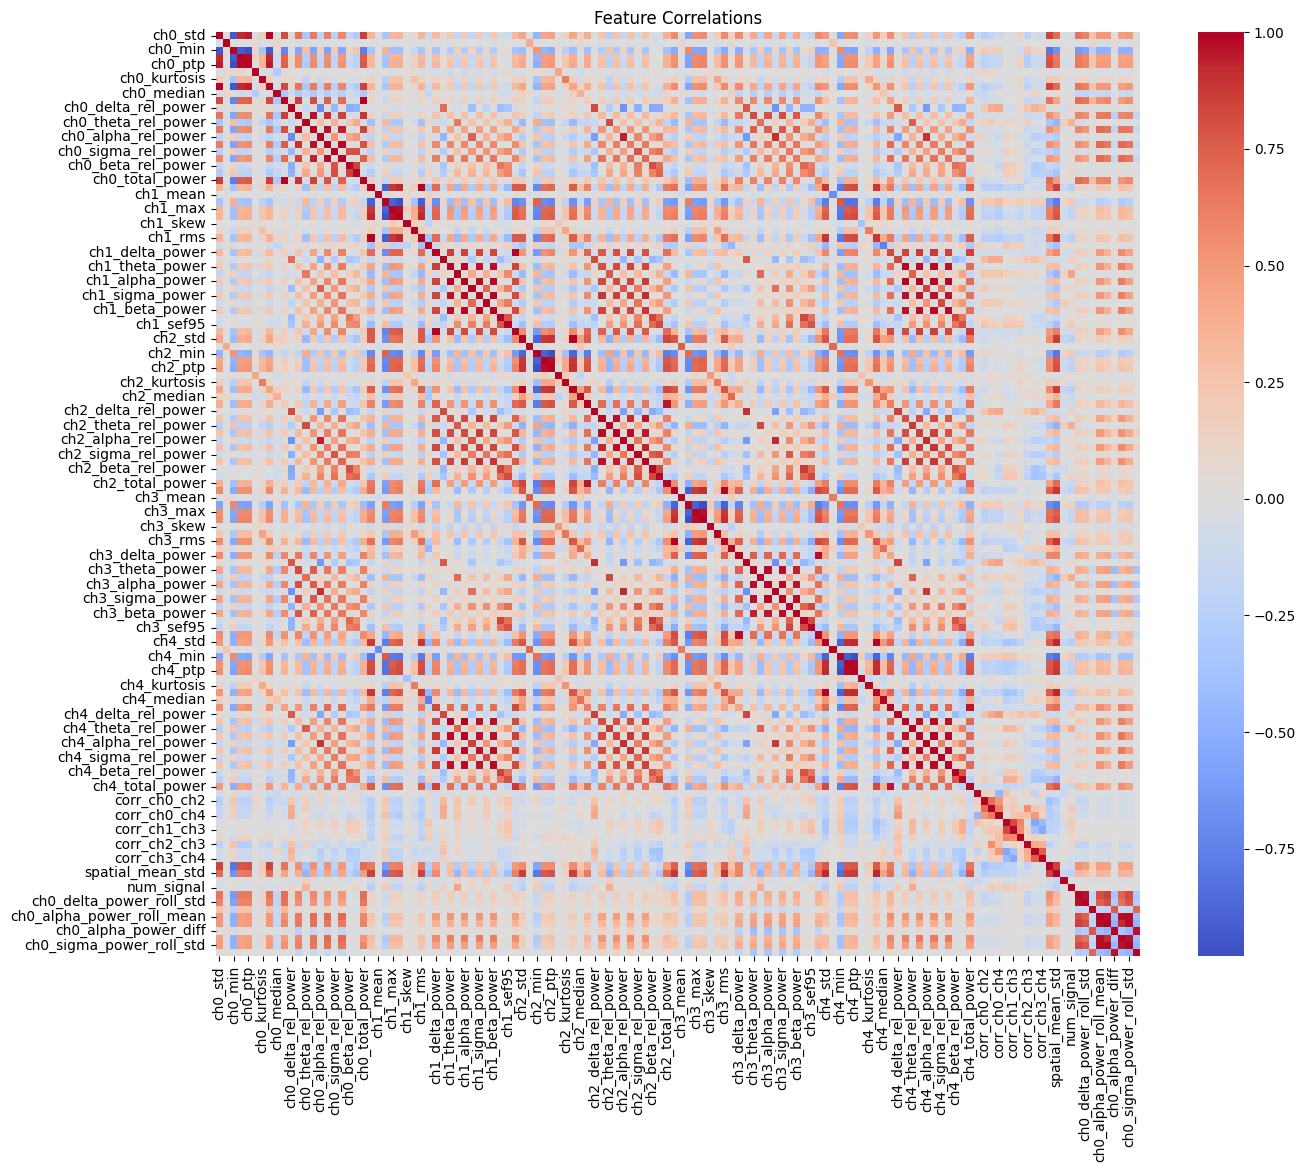

In [ ]:
## Pas tres travaille pour l'instant, je voulais voir les correls et enlever ce qui est trop correle mais dure de faire de la feature selection

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# Find highly correlated pairs (> 0.8 or <-0.8)
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

In [ ]:
df_features['target'] = df['target'].copy()

# sns.heatmap(df_features.corr()['target'])
# df_1.corr()
# df_1['target']
df_features.corr().loc[(np.abs(df_features.corr()['target']) > 0.45)]

,ch0_std,ch0_mean,ch0_min,ch0_max,ch0_ptp,ch0_skew,ch0_kurtosis,ch0_rms,ch0_median,ch0_delta_power,...,ch0_delta_power_roll_mean,ch0_delta_power_roll_std,ch0_delta_power_diff,ch0_alpha_power_roll_mean,ch0_alpha_power_roll_std,ch0_alpha_power_diff,ch0_sigma_power_roll_mean,ch0_sigma_power_roll_std,ch0_sigma_power_diff,target
ch2_alpha_rel_power,-0.156005,0.000479,0.140475,-0.125932,-0.135737,0.019035,-0.101742,-0.156019,-0.054394,-0.033929,...,-0.032813,-0.017488,-0.009983,0.028694,0.007035,-0.003512,0.003172,0.003415,-0.006953,-0.452471
ch2_sef95,-0.075857,-0.021976,0.018465,0.001206,-0.008721,0.016761,0.026327,-0.075881,-0.101949,0.073341,...,0.093066,0.117244,-0.007013,0.101748,0.098074,-0.017052,0.088345,0.095966,-0.015287,-0.453146
target,-0.128237,-0.001482,0.154355,-0.167322,-0.164017,-0.018235,-0.129883,-0.128237,0.028546,-0.092569,...,-0.097308,-0.099283,0.002413,-0.117649,-0.100116,0.022366,-0.105417,-0.104115,0.025286,1.000000


In [ ]:
def remove_correlated(df, high_corr, threshold=0.85):
    """Remove highly correlated features from DataFrame."""
    
    # Get features to drop
    to_drop = set()
    
    for f1, f2, corr in high_corr:
        if abs(corr) > threshold:
            # Drop the second feature in each pair
            to_drop.add(f2)
    
    # Remove features
    df_clean = df.drop(columns=list(to_drop))
    
    print(f"Dropped {len(to_drop)} features")
    print(f"Before: {df.shape}, After: {df_clean.shape}")
    
    return df_clean, list(to_drop)


df_clean, dropped = remove_correlated(df_features, high_corr, threshold=0.85)

Dropped 58 features
Before: (7433, 128), After: (7433, 70)


In [ ]:
df['target'].unique()

array([0, 1, 2, 4, 3], dtype=object)

## DeepL attempt

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



# Assuming df is your DataFrame and 'target' is the target column
X = df_features.drop('num_signal', axis=1)
y = df['target']

# Verify we have 5 classes
num_classes = 5
assert y.nunique() == num_classes, f"Expected 4 classes, found {y.nunique()}"

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

# Convert to one-hot encoding for Keras
y_onehot = keras.utils.to_categorical(y, num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,  # Add this
    verbose=1  # Changed to 1 to see progress
)

# Make predictions
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate F1 scores
f1_macro = f1_score(y_test_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test_classes, y_pred_classes, average='weighted')
f1_per_class = f1_score(y_test_classes, y_pred_classes, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

Class weights: {0: np.float64(1.2388333333333332), 1: np.float64(2.9206286836935167), 2: np.float64(0.4547568063628021), 3: np.float64(1.4377176015473887), 4: np.float64(1.046164672765658)}
Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5744 - loss: 1.1294 - val_accuracy: 0.6529 - val_loss: 1.0018
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6976 - loss: 0.7813 - val_accuracy: 0.7462 - val_loss: 0.7110
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7439 - loss: 0.6985 - val_accuracy: 0.7824 - val_loss: 0.6001
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7559 - loss: 0.6680 - val_accuracy: 0.7950 - val_loss: 0.5485
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7799 - loss: 0.5962 - val_accuracy: 0.8025 - val_loss: 0.5350
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7834 - loss: 0.5660 - val_accuracy: 0.8109 - val_loss: 0.5130
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

In [ ]:
#Run model on test
X_test = format_data(False)
X_test = create_features(X_test)
X_test_scaled = scaler.transform(X_test.drop('num_signal', axis=1))


# Make predictions
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)


s = create_submission(X_test, y_pred_classes, 'deepL_')

## Build Model

In [ ]:
## Cree une submition pour un model XGboost simple

# X_df, y = df_clean.drop(['num_signal'], axis=1), df['target']
# X_df, y = df_features_optimized.drop(['num_signal', 'target'], axis=1), df['target']

df_features
X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features_parallel(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)



# # Model that performed best for now
# model = XGBClassifier(
#     n_estimators=500,
#     max_depth=4,  # Deeper for complex patterns
#     learning_rate=0.05,  # Lower for better generalization
#     reg_lambda=1.0,  # L2 regularization
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     random_state=RANDOM_STATE
# )




# model = XGBClassifier(
#     n_estimators=500,
#     max_depth=8,  # Deeper for complex patterns
#     learning_rate=0.01,  # Lower for better generalization
#     reg_lambda=1.0,  # L2 regularization
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     random_state=RANDOM_STATE
# )



## Performed very shitty
# model = XGBClassifier(
#     n_estimators=800,
#     max_depth=3,                 # Shallower trees generalize better
#     learning_rate=0.03,          # Slower learning
#     subsample=0.7,               # Row subsampling (VERY important)
#     colsample_bytree=0.6,        # Feature subsampling
#     min_child_weight=5,          # Prevents learning noise
#     gamma=0.1,                   # Split penalty
#     reg_lambda=2.0,              # Stronger L2
#     reg_alpha=0.5,               # Add L1 regularization
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     tree_method='hist',          # Faster, more stable
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )

model.fit(X_train, y.astype(int))
predictions = model.predict(X_test)


model.fit(X_train, y)
predictions = np.argmax(model.predict_proba(X_test), axis=1)


create_submission(df_test, predictions, "less_param")

Processing 4077 epochs in parallel...
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_2800\1202604686.py:154: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## With sample weight
"""F1 Score (macro): 0.8860
F1 Score (weighted): 0.8835
Class 0 F1 Score: 0.9402
Class 1 F1 Score: 0.6462
Class 2 F1 Score: 0.9433
Class 3 F1 Score: 0.9561
Class 4 F1 Score: 0.9443"""

In [15]:
## Entrainement pour mon model XGBoost qui a le mieux marcher
# X_df, y = df_clean.drop(['num_signal'], axis=1), df['target']
# X_df, y = df_features_optimized.drop(['num_signal', 'target'], axis=1), df['target']

X_df, y = df_features.drop(['num_signal'], axis=1), df['target']




# 1. Split first
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=12)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Handle class imbalance (Stage N1 is rare!)
sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)

model.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model.predict(X_test)


f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_per_class = f1_score(y_test, predictions, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

F1 Score (macro): 0.8648
F1 Score (micro): 0.9112
Class 0 F1 Score: 0.9122
Class 1 F1 Score: 0.5876
Class 2 F1 Score: 0.9317
Class 3 F1 Score: 0.9452
Class 4 F1 Score: 0.9472


In [17]:
## Submission pour le model precedent (entrainement sur tout les data + creation du fichier de soumission)
# X_df, y = df_clean.drop(['num_signal'], axis=1), df['target']
# X_df, y = df_features_optimized.drop(['num_signal', 'target'], axis=1), df['target']

df_features
X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)


sample_weights = compute_sample_weight('balanced', y)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)

model.fit(X_train, y, sample_weight=sample_weights)
predictions = model.predict(X_test)


create_submission(df_test, predictions)

Processing 4077 epochs...
  Progress: 0/4077 epochs
  Progress: 100/4077 epochs
  Progress: 200/4077 epochs
  Progress: 300/4077 epochs
  Progress: 400/4077 epochs
  Progress: 500/4077 epochs
  Progress: 600/4077 epochs
  Progress: 700/4077 epochs
  Progress: 800/4077 epochs
  Progress: 900/4077 epochs
  Progress: 1000/4077 epochs
  Progress: 1100/4077 epochs
  Progress: 1200/4077 epochs
  Progress: 1300/4077 epochs
  Progress: 1400/4077 epochs
  Progress: 1500/4077 epochs
  Progress: 1600/4077 epochs
  Progress: 1700/4077 epochs
  Progress: 1800/4077 epochs
  Progress: 1900/4077 epochs
  Progress: 2000/4077 epochs
  Progress: 2100/4077 epochs
  Progress: 2200/4077 epochs
  Progress: 2300/4077 epochs
  Progress: 2400/4077 epochs
  Progress: 2500/4077 epochs
  Progress: 2600/4077 epochs
  Progress: 2700/4077 epochs
  Progress: 2800/4077 epochs
  Progress: 2900/4077 epochs
  Progress: 3000/4077 epochs
  Progress: 3100/4077 epochs


C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': float(skew(signal)),
C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': float(kurtosis(signal)),
C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:119: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(channel_signals[i], channel_signals[j])


  Progress: 3200/4077 epochs
  Progress: 3300/4077 epochs
  Progress: 3400/4077 epochs
  Progress: 3500/4077 epochs
  Progress: 3600/4077 epochs
  Progress: 3700/4077 epochs
  Progress: 3800/4077 epochs
  Progress: 3900/4077 epochs
  Progress: 4000/4077 epochs
Adding temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:152: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:152: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
C:\Users\mathias\AppData\Local\Temp\ipykernel_20496\2337337202.py:152: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## Score with multiple windows
"""
F1 Score (macro): 0.8783
F1 Score (weighted): 0.8835
Class 0 F1 Score: 0.9341
Class 1 F1 Score: 0.6073
Class 2 F1 Score: 0.9453
Class 3 F1 Score: 0.9555
Class 4 F1 Score: 0.9493
"""


## Score with widow = 1000 
"""
F1 Score (macro): 0.8669
F1 Score (weighted): 0.8835
Class 0 F1 Score: 0.9363
Class 1 F1 Score: 0.5806
Class 2 F1 Score: 0.9423
Class 3 F1 Score: 0.9557
Class 4 F1 Score: 0.9195
"""

## Score with optimized
"""F1 Score (macro): 0.8613
F1 Score (weighted): 0.8782
Class 0 F1 Score: 0.9349
Class 1 F1 Score: 0.5475
Class 2 F1 Score: 0.9427
Class 3 F1 Score: 0.9557
Class 4 F1 Score: 0.9258"""

In [ ]:
# Grid serach to find the best XG boost classifier

# param_dist = {
#     'n_estimators': [300, 500, 700, 1000],
#     'max_depth': [5, 7, 9, 11],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
# }

# xgb_search = RandomizedSearchCV(
#     XGBClassifier(random_state=RANDOM_STATE),
#     param_dist,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=3,
#     random_state=RANDOM_STATE,
#     n_jobs=-1
# )

# xgb_search.fit(X_train, y_train, sample_weight=sample_weights)
# best_model = xgb_search.best_estimator_

# # Save the model and the scaler
# joblib.dump(best_model, 'best_xgboost_model.joblib')
# joblib.dump(scaler, 'scaler.joblib')


best_model = joblib.load('best_xgboost_model.joblib')
scaler = joblib.load('scaler.joblib')

predictions = best_model.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=RANDOM_STATE)
y_train = y_train.astype(int)
y_test = y_test.astype(int)



# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_weighted = f1_score(y_test, predictions, average='weighted')

print(f"Macro F1 Score: {f1_macro:.4f}")
print(f"Micro F1 Score: {f1_micro:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")


# Create submission using data
df_test = format_data(False)
X_df_test = create_features(df_test)
X_test = scaler.transform(X_df_test.drop('num_signal', axis=1))


predictions = best_model.predict(X_test)
sub = create_submission(df_test, predictions)


In [ ]:
# Grid search pour meilleur random forrest

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import f1_score, classification_report
# import numpy as np

# y = y.astype(int)
# # Use original data (not scaled) for Random Forest
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # Define Random Forest with class_weight='balanced' for handling imbalance
# rf = RandomForestClassifier(
#     class_weight='balanced',
#     random_state=42,
#     n_jobs=-1
# )

# # Simple parameter grid focusing on key parameters
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [20, 30, 40, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# # Perform grid search using F1-macro (handles imbalance well)
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=5,
#     scoring='f1_macro',
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get best model
# best_rf = grid_search.best_estimator_

# # Make predictions
# y_pred = best_rf.predict(X_test)

# # Evaluate
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best CV Score (F1 Macro): {grid_search.best_score_:.4f}")

# f1_macro = f1_score(y_test, y_pred, average='macro')
# f1_weighted = f1_score(y_test, y_pred, average='weighted')
# f1_per_class = f1_score(y_test, y_pred, average=None)

# print(f"\nTest Set Results:")
# print(f"F1 Macro: {f1_macro:.4f}")
# print(f"F1 Weighted: {f1_weighted:.4f}")

# print("\nPer-class F1 Scores:")
# for class_idx, score in enumerate(f1_per_class):
#     print(f"  Class {class_idx}: {score:.4f}")



# """Fitting 5 folds for each of 216 candidates, totalling 1080 fits
# Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
# Best CV Score (F1 Macro): 0.8302

# Test Set Results:
# F1 Macro: 0.8189
# F1 Weighted: 0.8735

# Per-class F1 Scores:
#   Class 0: 0.8880
#   Class 1: 0.5027
#   Class 2: 0.9115
#   Class 3: 0.9187
#   Class 4: 0.8739"""

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score (F1 Macro): 0.8302

Test Set Results:
F1 Macro: 0.8189
F1 Weighted: 0.8735

Per-class F1 Scores:
  Class 0: 0.8880
  Class 1: 0.5027
  Class 2: 0.9115
  Class 3: 0.9187
  Class 4: 0.8739


In [18]:
# Cree une submission pour une random forest facile
rf = RandomForestClassifier(
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)


rf.fit(X_train, y.astype(int))
predictions = rf.predict(X_test)

create_submission(df_test, predictions, 'rf_')

labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## Random forest qui sait que le dataset est unbalanced
from imblearn.over_sampling import SMOTE

# 1. Apply SMOTE first
smote = SMOTE(sampling_strategy={1: 1500}, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)



# 2. Train with moderate weights on resampled data
rf = RandomForestClassifier(
    max_depth=30, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    class_weight={0: 1, 1: 6, 2: 1, 3: 1, 4: 1},  # Lower weight now
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train_sm, y_train_sm)


y_pred = rf.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"\nTest Set Results:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

print("\nPer-class F1 Scores:")
for class_idx, score in enumerate(f1_per_class):
    print(f"  Class {class_idx}: {score:.4f}")


ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
# SVM pour voir comment cela performe
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM with custom class weights
svm = SVC(
    kernel='rbf',  # or 'linear', 'poly'
    C=1.0,
    gamma='scale',
    class_weight={0: 1, 1: 6, 2: 1, 3: 1, 4: 1},  # Boost class 1
    random_state=42,
    probability=False  # Enable if you need predict_proba
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"\nTest Set Results:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print("\nPer-class F1 Scores:")
for class_idx, score in enumerate(f1_per_class):
    print(f"  Class {class_idx}: {score:.4f}")


Test Set Results:
F1 Macro: 0.7947
F1 Weighted: 0.8554

Per-class F1 Scores:
  Class 0: 0.8534
  Class 1: 0.4654
  Class 2: 0.9092
  Class 3: 0.9189
  Class 4: 0.8266
